Loading os and trying to use GPU 

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
# check tf version
print(tf.__version__)

gpus = tf.config.list_physical_devices('GPU')
for device in gpus:
    tf.config.experimental.set_memory_growth(device, True)
    print(f"Found GPU {device.name}, and set memory growth to True.")


2.20.0


In [2]:
#base path is the location of the repo on your computer
BASE_PATH = r"C:\Users\avark\Documents\snek"
#BASE_PATH = r"D:\Egyetem_adat"

In [3]:
from sklearn.preprocessing import LabelEncoder

species = pd.read_csv(r"D:\Egyetem_adat\train_images_metadata.csv", index_col=0)
venomous = pd.read_csv(r"D:\Egyetem_adat\venomous_status_metadata.csv", index_col=0)

"""
#read the train_images_metadata.csv file
species = pd.read_csv(BASE_PATH + r"\src\Data\train_images_metadata.csv", index_col=0)

#read the venomous_status_metadata.csv file
venomous = pd.read_csv(BASE_PATH + r"\src\Data\venomous_status_metadata.csv", index_col=0)
"""
#merging the 2 files, now every row from species contains a column with venomous status
combined = species.merge(venomous[["class_id", "MIVS"]], on="class_id", how="left")

#choosing the data you need for machine learning
relevant_info = combined[["binomial_name", "class_id", "MIVS", "image_path"]]

#encoded_id is same as class_id, but starts from 0
encoder = LabelEncoder()
relevant_info["encoded_id"] = encoder.fit_transform(relevant_info["class_id"])
num_classes = len(encoder.classes_)


print(relevant_info.head())

         binomial_name  class_id  MIVS      image_path  encoded_id
0       Bitis caudalis       157     0      168482.JPG           9
1   Amphiesma stolatum        66     0    59067968.jpg           3
2        Lachesis muta       857     1    42704088.jpg         126
3         Vipera berus      1736     1  111487306.jpeg         284
4  Coronella austriaca       387     0  111486989.jpeg          49


<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:8: SyntaxWarning: invalid escape sequence '\s'
C:\Users\janos\AppData\Local\Temp\ipykernel_14980\2163187207.py:8: SyntaxWarning: invalid escape sequence '\s'
  species = pd.read_csv(BASE_PATH + r"\src\Data\train_images_metadata.csv", index_col=0)
C:\Users\janos\AppData\Local\Temp\ipykernel_14980\2163187207.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_info["encoded_id"] = encoder.fit_transform(relevant_info["class_id"])


Loading python images from folder

In [4]:
AUTOTUNE = tf.data.AUTOTUNE

IMAGE_RESOLUTION=28


# Create a TensorFlow dataset for image loading
def load_img(path):
    img = tf.io.read_file(path)

    #3 channels because of rgb
    #img = tf.image.decode_jpeg(img, 3)
    #expand_animations = False needed, otherwise it
    img = tf.image.decode_image(img, channels=3, expand_animations = False)  
    img = tf.image.resize(img, [IMAGE_RESOLUTION, IMAGE_RESOLUTION])
    img = img / 255.0  # Normalize to [0, 1]
    return img

# Find all of the image_paths 
#image_path = [os.path.join(BASE_PATH, 'src', 'Data', 'train_images_small', img_path) for img_path in relevant_info['image_path'].values]
image_path = [os.path.join(r"D:\Egyetem_adat\train_images_small\train_images_small", img_path) for img_path in relevant_info['image_path'].values]

# Create the dataset and apply transformations
ds = tf.data.Dataset.from_tensor_slices(image_path)
ds = ds.map(load_img, num_parallel_calls=AUTOTUNE)  # Load images in parallel
ds = ds.batch(32).prefetch(AUTOTUNE)  # Batch and prefetch for efficiency


In [12]:

# Labels are going to be either venomous, or non-venomous
labels_species = relevant_info['encoded_id'].values
labels_venom = relevant_info['MIVS'].values

#return processed image and corresponding label
def generator():
    for img_path, species_label, venom_label in zip(image_path, labels_species, labels_venom):
        img = load_img(img_path)
        yield img, {'species': species_label, 'venom': venom_label}


# Create dataset
dataset = tf.data.Dataset.from_generator(
    generator,
    output_signature=(
        tf.TensorSpec(shape=(IMAGE_RESOLUTION, IMAGE_RESOLUTION, 3), dtype=tf.float32),
        {
            'species': tf.TensorSpec(shape=(), dtype=tf.int32),
            'venom': tf.TensorSpec(shape=(), dtype=tf.int32)
        }
    )
)

# Batch and prefetch for efficiency
BATCH_SIZE = 32
dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [24]:
from sklearn.model_selection import train_test_split

#train_image_paths = [os.path.join(BASE_PATH, 'src', 'Data', 'train_images_small', path) for path in relevant_info["image_path"]]
train_image_paths = [os.path.join(r"D:\Egyetem_adat\train_images_small\train_images_small", path) for path in relevant_info["image_path"]]

labels_species = relevant_info['encoded_id'].values
labels_venom   = relevant_info['MIVS'].values

train_image_paths, temp_image_paths, train_species_labels, temp_species_labels, train_venom_labels, temp_venom_labels = train_test_split(
    train_image_paths, labels_species, labels_venom, test_size=0.2, random_state=42, stratify=labels_species
)

val_image_paths, test_image_paths, val_species_labels, test_species_labels, val_venom_labels, test_venom_labels = train_test_split(
    temp_image_paths, temp_species_labels, temp_venom_labels, test_size=0.5, random_state=42, stratify=temp_species_labels
)

# Train dataset
train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_image_paths, {'species': train_species_labels, 'venom': train_venom_labels})
)
train_dataset = train_dataset.map(
    lambda x, y: (load_img(x), y),
    num_parallel_calls=tf.data.AUTOTUNE
)
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices(
    (val_image_paths, {'species': val_species_labels, 'venom': val_venom_labels})
)
val_dataset = val_dataset.map(
    lambda x, y: (load_img(x), y),
    num_parallel_calls=tf.data.AUTOTUNE
)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)



In [25]:
from tensorflow.keras.layers import Flatten, Conv2D, Dense, Input, MaxPooling2D, Dropout, Rescaling
from tensorflow.keras import Model

from re import X

input = Input(shape=(IMAGE_RESOLUTION, IMAGE_RESOLUTION, 3))
x = Rescaling(1./255)(input)

x = Conv2D(32, (3,3), padding='same', activation="relu")(input)
x = MaxPooling2D((2,2), padding='valid')(x)

x = Conv2D(64, (3,3), padding='same', activation="relu")(x)
x = MaxPooling2D((2,2), padding='valid')(x)

x = Conv2D(128, (3,3), padding='same', activation="relu")(x)
x = MaxPooling2D((2,2), padding='valid')(x)

x = Conv2D(32, (3,3), padding='same', activation="relu")(x)
x = MaxPooling2D((2,2), padding='valid')(x)

x = Flatten()(x)

x = Dense(128, activation='relu')(x)

x = Dropout(0.3)(x)

species_output = Dense(num_classes, activation='softmax', name='species')(x)
venom_output = Dense(1, activation='sigmoid', name='venom')(x)

model = Model(inputs=input, outputs=[species_output, venom_output])

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 28, 28, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 28, 28,    │        896 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 14, 14,    │          0 │ conv2d_12[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 14, 14,    │     18,496 │ max_pooling2d_12… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 7, 7, 64)  │          0 │ conv2d_13[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 7, 7, 128) │     73,856 │ max_pooling2d_13… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, 3, 3, 128) │          0 │ conv2d_14[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 3, 3, 32)  │     36,896 │ max_pooling2d_14… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_15    │ (None, 1, 1, 32)  │          0 │ conv2d_15[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 32)        │          0 │ max_pooling2d_15… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │      4,224 │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ species (Dense)     │ (None, 296)       │     38,184 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ venom (Dense)       │ (None, 1)         │        129 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 172,681 (674.54 KB)

 Trainable params: 172,681 (674.54 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
model.compile(
    optimizer='adam',
    loss={'species': 'sparse_categorical_crossentropy', 'venom': 'binary_crossentropy'},
    metrics={'species': 'accuracy', 'venom': 'accuracy'}
    )

In [27]:
n_epochs = 10  # number of epochs to train the neural network
# checkpointing based on the validation loss
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint('model.keras', monitor='val_loss', save_best_only=True, save_weights_only=False, verbose=1)

# model training
model_history = model.fit(
                            x= train_dataset,
                            epochs= n_epochs,
                            validation_data= val_dataset,
                            callbacks=[model_checkpoint_callback])

model.load_weights('model.keras')  # load weights back

Epoch 1/10
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 5.9985 - species_accuracy: 0.0241 - species_loss: 5.4870 - venom_accuracy: 0.7968 - venom_loss: 0.5114
Epoch 1: val_loss improved from None to 5.82385, saving model to model.keras
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 46s 27ms/step - loss: 5.9238 - species_accuracy: 0.0287 - species_loss: 5.4191 - venom_accuracy: 0.7996 - venom_loss: 0.5047 - val_loss: 5.8238 - val_species_accuracy: 0.0343 - val_species_loss: 5.3235 - val_venom_accuracy: 0.7998 - val_venom_loss: 0.5006
Epoch 2/10
1661/1662 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.8271 - species_accuracy: 0.0325 - species_loss: 5.3260 - venom_accuracy: 0.7998 - venom_loss: 0.5011
Epoch 2: val_loss improved from 5.82385 to 5.76152, saving model to model.keras
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 27s 16ms/step - loss: 5.8042 - species_accuracy: 0.0338 - species_loss: 5.3041 - venom_accuracy: 0.7999 - venom_loss: 0.5000 - val_loss: 5.7615 - val_species_accuracy: 0.0369 - val_species_loss

In [30]:
# Create TensorFlow datasets for test
test_dataset = tf.data.Dataset.from_tensor_slices(
    (test_image_paths, {'species': test_species_labels, 'venom': test_venom_labels})
)
# Apply preprocessing and map to TensorFlow dataset
test_dataset = test_dataset.map(lambda x, y: (load_img(x), y), num_parallel_calls=tf.data.AUTOTUNE)

# Batch and prefetch the datasets for efficiency
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [31]:
test_history = model.evaluate(test_dataset)
print("Test Loss: ", test_history[0])
print("Test Accuracy: ", test_history[1])

208/208 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 5.5749 - species_accuracy: 0.0527 - species_loss: 5.0887 - venom_accuracy: 0.8012 - venom_loss: 0.4859
Test Loss:  5.574871063232422
Test Accuracy:  5.0887041091918945


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


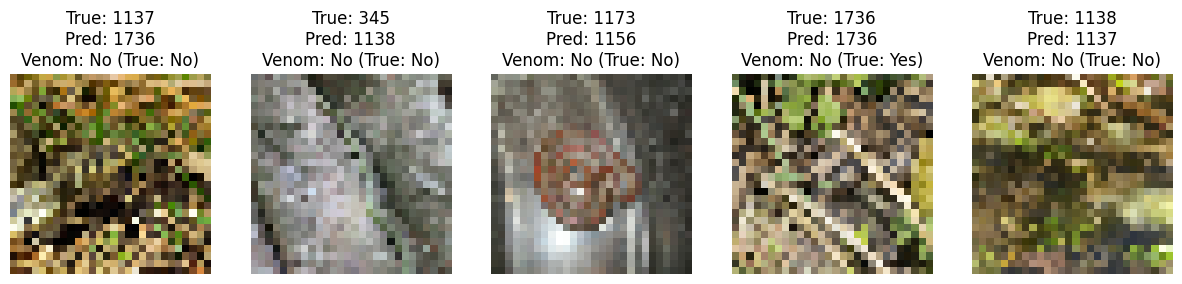

D:\Egyetem_adat\train_images_small\train_images_small\185879544.jpg
D:\Egyetem_adat\train_images_small\train_images_small\104808480.jpg
D:\Egyetem_adat\train_images_small\train_images_small\22038544.jpeg
D:\Egyetem_adat\train_images_small\train_images_small\120048815.jpg
D:\Egyetem_adat\train_images_small\train_images_small\156950119.jpeg


In [ ]:
#show a few results

def plot_example_results(model, image_paths, true_species_labels, true_venom_labels, num_examples=5):
    indices = np.random.choice(len(image_paths), size=num_examples, replace=False)
    
    plt.figure(figsize=(15, 5))
    
    for i, index in enumerate(indices):
        image_path = image_paths[index]
        true_species = true_species_labels[index]
        true_venom = true_venom_labels[index]
    
        image = load_img(image_path)
        image = tf.expand_dims(image, axis=0)
        
        # Model returns [species_pred, venom_pred]
        species_pred, venom_pred = model.predict(image)
        
        predicted_species = np.argmax(species_pred, axis=1)[0]
        predicted_venom = (venom_pred > 0.5).astype(int)[0][0]
        
        plt.subplot(1, num_examples, i+1)
        plt.imshow(image[0])
        plt.axis('off')
        plt.title(f"True: {true_species}, {'Venom' if true_venom else 'Safe'}\n"
                  f"Pred: {predicted_species}, {'Venom' if predicted_venom else 'Safe'}")
    
    plt.show()
    
    return [image_paths[i] for i in indices]


ex = plot_example_results(model, test_image_paths, test_species_labels, test_venom_labels, num_examples=5)

for i in range(len(ex)):
    print(ex[i])
